Importing required packages for the project

In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

import sys
import warnings
import datetime as dt
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [16]:
from math import floor,ceil,sqrt
from pmdarima.arima import auto_arima
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from sklearn.metrics import r2_score

In [17]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")


Loading the data for the prediction

In [4]:
df = pd.read_csv("C:/Users/KUMARAGURU/OneDrive/Documents/MSFT.csv")
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.062549,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.064783,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.065899,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.064224,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.063107,47894400
5,1986-03-20,0.098090,0.098090,0.094618,0.095486,0.061432,58435200
6,1986-03-21,0.095486,0.097222,0.091146,0.092882,0.059756,59990400
7,1986-03-24,0.092882,0.092882,0.089410,0.090278,0.058081,65289600
8,1986-03-25,0.090278,0.092014,0.089410,0.092014,0.059198,32083200
9,1986-03-26,0.092014,0.095486,0.091146,0.094618,0.060873,22752000


Data preprocessing, changed the format of date column from YYYY-MM-DD to MM/DD/YYYY HH:MM:SS in excel.

In [5]:
df=pd.read_csv("C:/Users/KUMARAGURU/OneDrive/Documents/MSFT_PREPROCESSED.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,03/13/1986 00:00:00,0.088542,0.101563,0.088542,0.097222,0.062549,1031788800
1,03/14/1986 00:00:00,0.097222,0.102431,0.097222,0.100694,0.064783,308160000
2,03/17/1986 00:00:00,0.100694,0.103299,0.100694,0.102431,0.065899,133171200
3,03/18/1986 00:00:00,0.102431,0.103299,0.098958,0.099826,0.064224,67766400
4,03/19/1986 00:00:00,0.099826,0.100694,0.097222,0.098090,0.063107,47894400
...,...,...,...,...,...,...,...
8520,12/31/2019 00:00:00,156.770004,157.770004,156.449997,157.699997,157.699997,18369400
8521,01/02/2020 00:00:00,158.779999,160.729996,158.330002,160.619995,160.619995,22622100
8522,01/03/2020 00:00:00,158.320007,159.949997,158.059998,158.619995,158.619995,21116200
8523,01/06/2020 00:00:00,157.080002,159.100006,156.509995,159.029999,159.029999,20813700


Data preprocessing, changed the format of date column from YYYY-MM-DD to MM/DD/YYYY HH:MM:SS, completing the action with pandas and indexing with date. Plotting the dataset.

Text(0.5, 1.0, 'Stock Price of Microsoft over the Years')

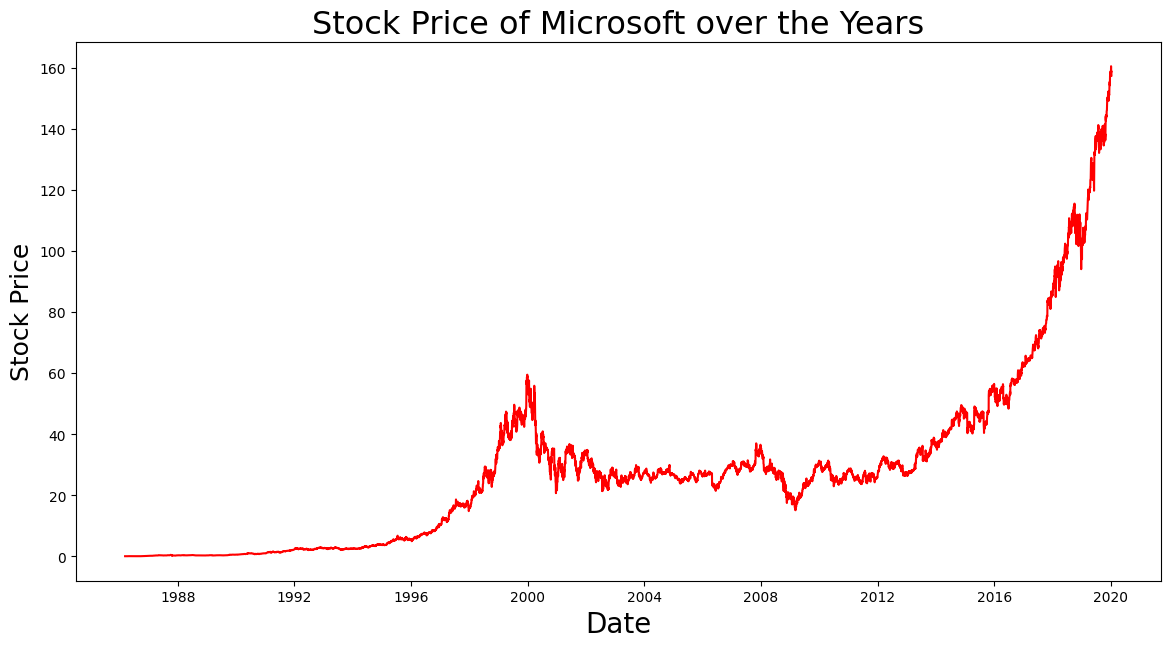

In [20]:
df['Date'] = pd.to_datetime(df.Date,format='%m/%d/%Y %H:%M:%S')
df.index = df['Date']
plt.figure(figsize=(14,7))
plt.plot(df['Close'], label='Close Price history',color='r')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=18)
plt.title('Stock Price of Microsoft over the Years',size=23)

In [27]:
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [32]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Moving average model for comparision purpose. RMSE and r2 score is used to evaluate the model performance. The prediction is plotted along with the actual values. The model is trained using the interquartile range in the data and tested against the fourth quartile 

In [21]:
def Moving_Average_Prediction(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.head()
    train__data_set=df_new.iloc[ceil(shape*0.25):ceil(shape*0.80)]
    valid__data_set=df_new.iloc[ceil(shape*0.75):]
    print("***** Microsoft Stock Price Prediction Using Moving Averages*********")
    print('Shape of Training Data Set of Microsft Stock Prices',train__data_set.shape)
    print('Shape of Validating Data Set of Microsft Stock Prices',valid__data_set.shape)
    preds = []
    for i in range(0,valid__data_set.shape[0]):
        a = train__data_set['Close'][len(train__data_set)-valid__data_set.shape[0]+i:].sum() + sum(preds)
        b = a/(valid__data_set.shape[0])
        preds.append(b)
    RMS=np.sqrt(np.mean(np.power((np.array(valid__data_set['Close'])-preds),2)))
    r2= r2_score(valid__data_set,preds)
    print('(Root Mean Square Error) RMSE value on validation set:',RMS)
    print('(R2 Score)R2 value on validation set:',r2)
    valid__data_set['Predictions'] = preds
    plt.plot(train__data_set['Close'])
    plt.plot(valid__data_set[['Close', 'Predictions']])
    plt.xlabel('Date',size=18)
    plt.ylabel('Stock Price',size=18)
    plt.title('Stock Price Prediction by Moving Averages',size=18)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

***** Microsoft Stock Price Prediction Using Moving Averages*********
Shape of Training Data Set of Microsft Stock Prices (4688, 1)
Shape of Validating Data Set of Microsft Stock Prices (2131, 1)
(Root Mean Square Error) RMSE value on validation set: 48.88457740518917
(R2 Score)R2 value on validation set: -1.0234099920313238


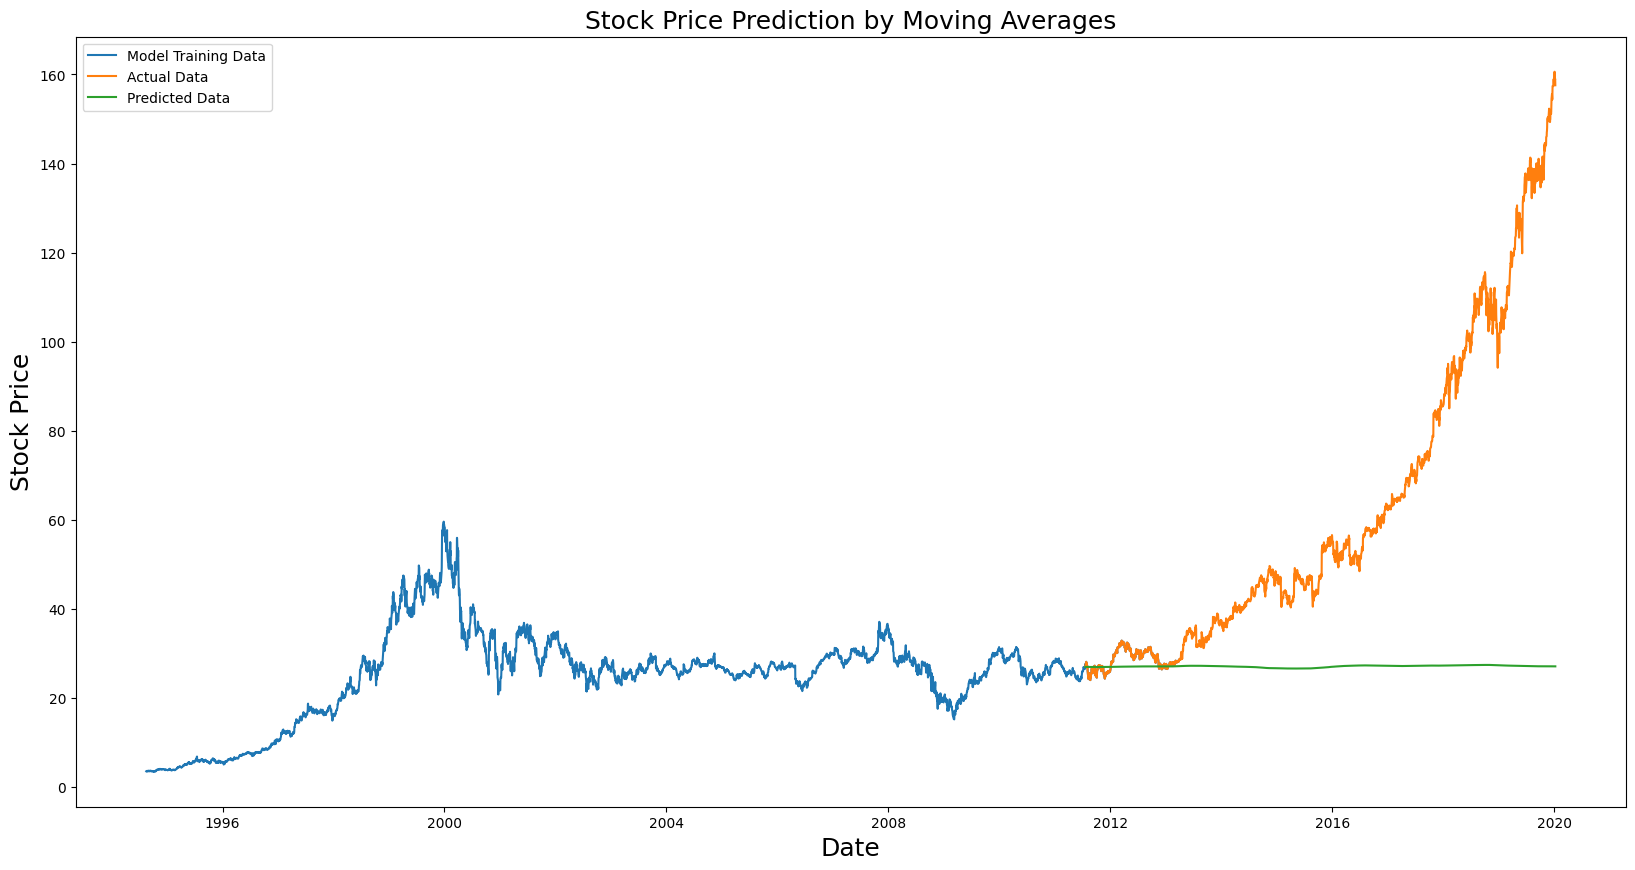

In [22]:
Moving_Average_Prediction(df)

The project proposal LSTM model for predicting stock price data.  RMSE and r2 score is used to evaluate the model performance. The prediction is plotted along with the actual values. The model is trained using near interquartile range in the data and tested against the fourth quartile. It is trainned for one epoch by keeping batch size 1.

In [30]:
def LSTM_Prediction(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.head()
    dataset = df_new.values
    train=df_new[ceil(shape*0.30):ceil(shape*0.80)]
    valid=df_new[ceil(shape*0.75):]
    print("******** Microsoft STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM) *******")
    print('Shape of Training data Set',train.shape)
    print('Shape of Validation data Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    X_train, Y_train = [], []
    for i in range(40,len(train)):
        X_train.append(scaled_data[i-40:i,0])
        Y_train.append(scaled_data[i,0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    Y_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    Model = Sequential()
    Model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
    Model.add(LSTM(units=50))
    Model.add(Dense(1))
    Model.compile(loss='mean_squared_error', optimizer='adam')
    Model.fit(X_train, Y_train, epochs=1, batch_size=2, verbose=2)
    inputs = df_new[len(df_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = Model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    RMS=np.sqrt(np.mean(np.power((valid-closing_price),2)))
    r2 = r2_score(valid-closing_price ,closing_price )
    print('(R2 score)R2 value on validation set:', r2)
    print('(Root Neab Square Error) RMSE value on validation set:',RMS)
    valid['Predictions'] = closing_price
    plt.plot(train['Close'])
    plt.plot(valid[['Close','Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Microsoft Stock Price Prediction by Long Short Term Memory (LSTM)',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

******** Microsoft STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM) *******
Shape of Training data Set (4262, 1)
Shape of Validation data Set (2131, 1)
2111/2111 - 65s - loss: 2.5536e-04 - 65s/epoch - 31ms/step
67/67 [==============================] - 3s 20ms/step
(R2 score)R2 value on validation set: -82.5785420245649
(Root Neab Square Error) RMSE value on validation set: Close    7.440627
dtype: float64


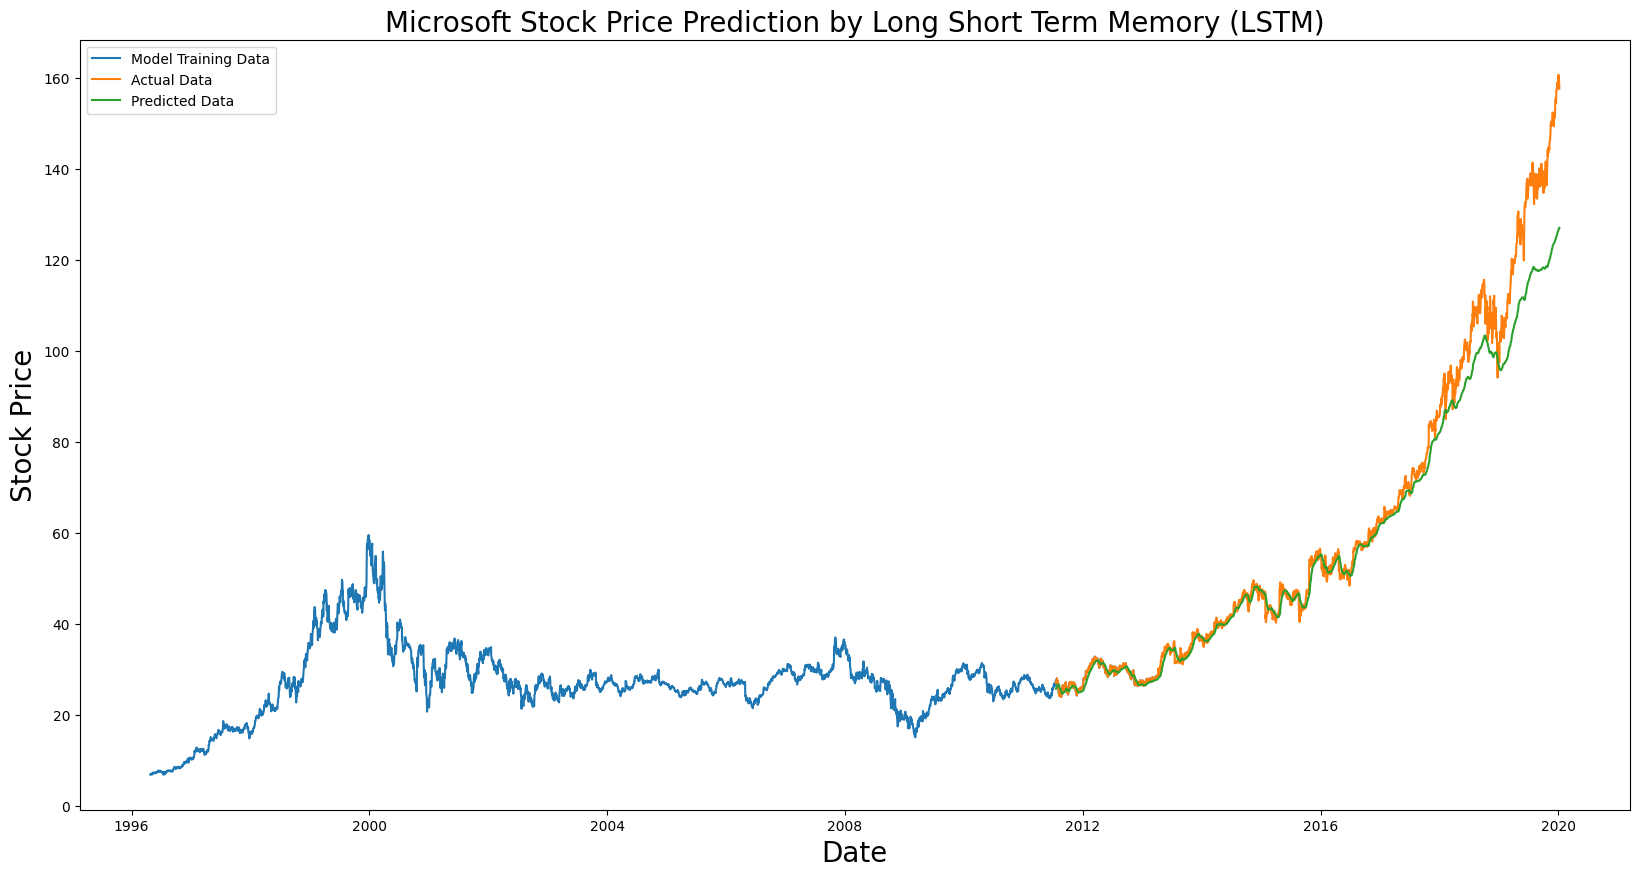

In [31]:
LSTM_Prediction(df)

Moving average performance metrices :
    RMSE:48.88457740518917
    r2:-1.0234099920313238

LSTM performance metrices :
    RMSE:7.440627
    r2:-82.5785420245649